In [2]:
import numpy as np
from scipy.optimize import minimize_scalar, curve_fit
# from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from matplotlib.gridspec import GridSpec
from scipy.interpolate import CubicSpline

In [3]:
# Constants
k_B = 1.38e-23                  # Boltzmann constant in J/K
sigma = 0.0098                  # Surface tension in J/m²
a = 270e-9                      # Droplet radius in meters
xi = 0.15                       # Dimensionless parameter
epsilon_r = 78.5                # Relative permittivity of water
epsilon_0 = 8.85e-12            # Permittivity of vacuum in F/m
phi_c = 0.646                   # Critical volume fraction
alpha = 0.85                    # Shear effect parameter
e = 1.602e-19                   # Elementary charge in C
N_A = 6.0221e23                 # Avogadro's number in mol⁻¹
R = 8.314                       # Gas constant in J/(mol·K)
F = N_A * e                     # Faraday's constant in C/mol
I = 8.2e-3                      # Ionic strength in mol/L
V_drop = (4/3) * np.pi * a**3   # Droplet volume in cubic meters
z = 1                           # Valence of the ions (monovalent for SDS)
c_0 = 10                        # Bulk molar concentration in mol/m³ (10 mM)

In [4]:
def compute_lambda_D(T):
    numerator = epsilon_r * epsilon_0 * k_B * T
    denominator = 2 * e**2 * I  * N_A  * 1e3
    lambda_D = np.sqrt(numerator / denominator)
    return lambda_D

In [5]:
compute_lambda_D(298)

3.357343068814714e-09

In [6]:
print(f" At temperature 298K, Debye length λ_D ≈ {round(compute_lambda_D(298)*1e9,1)} nm")

 At temperature 298K, Debye length λ_D ≈ 3.4 nm


In [7]:
def compute_psi_0(T):
    sigma_e = 2 * e / (1e-18)  # Convert 2 e/nm² to C/m²
    numerator = 2 * k_B * T / (z * e)
    denominator = np.sqrt(8 * c_0 * epsilon_r * epsilon_0 * R * T)
    argument = sigma_e / denominator
    psi_0 = numerator * np.arcsinh(argument)
    return psi_0

In [8]:
compute_psi_0(298)

0.2053899583186848

In [9]:
print(f" At temperature 298K, Surface potential ψ_0 ≈{int(round(compute_psi_0(298),2)*1e3)} mV")

 At temperature 298K, Surface potential ψ_0 ≈210 mV


In [10]:
def F_int(phi_d):
    return 4 * np.pi * xi * sigma * (a**2) * (phi_d**2)

def F_ent(phi, phi_d, gamma, T):
    term = phi_c + phi_d - phi - alpha * gamma**2
    if term <= 0:
        return np.inf  # Avoid log of non-positive number
    return -3 * k_B * T * np.log(term)

def F_elec(phi_d, phi, gamma, T):
    term = phi_c + phi_d - alpha * gamma**2
    if term <= 0:
        return np.inf
    h = 2 * (phi_c)**(1/3) * a * (phi**(-1/3) - term**(-1/3))
    if h <= 0:
        return np.inf
    lambda_D = compute_lambda_D(T)
    psi_0 = compute_psi_0(T)
    numerator = 2 * np.pi * a**2 * epsilon_r * epsilon_0 * psi_0**2 * np.exp(-h / lambda_D)
    return numerator / h

def F_tot(phi_d, phi, gamma, T):
    return F_int(phi_d) + F_ent(phi, phi_d, gamma, T) + F_elec(phi_d, phi, gamma, T)

# Function to find the minimum of phi_d
def find_min_phi_d(phi, gamma, T):
    boundary_condition = phi_c - phi - alpha * gamma**2
    if boundary_condition > 0:
        lower_bound = 0.0
    else:
        lower_bound = phi + alpha * gamma**2 - phi_c
    # Ensure upper_bound is greater than lower_bound
    upper_bound = max(lower_bound + 1e-6, 1.0)  # Set upper_bound to at least lower_bound + small delta
    def objective(phi_d):
        return F_tot(phi_d, phi, gamma, T)
    result = minimize_scalar(objective, bounds=(lower_bound, upper_bound), method='bounded')
    return result.x, result.fun

In [11]:
T_variable = 298  # Temperature in Kelvin (can now be varied)
phi_example = 0.3  # Example volume fraction
gamma_example = 0  # Example shear rate parameter

phi_d_min, F_min = find_min_phi_d(phi_example, gamma_example, T_variable)
print(f"Minimum phi_d: {phi_d_min}, Minimum Free Energy: {F_min}")

Minimum phi_d: 1.3238510763446943e-05, Minimum Free Energy: 1.3093437951742552e-20


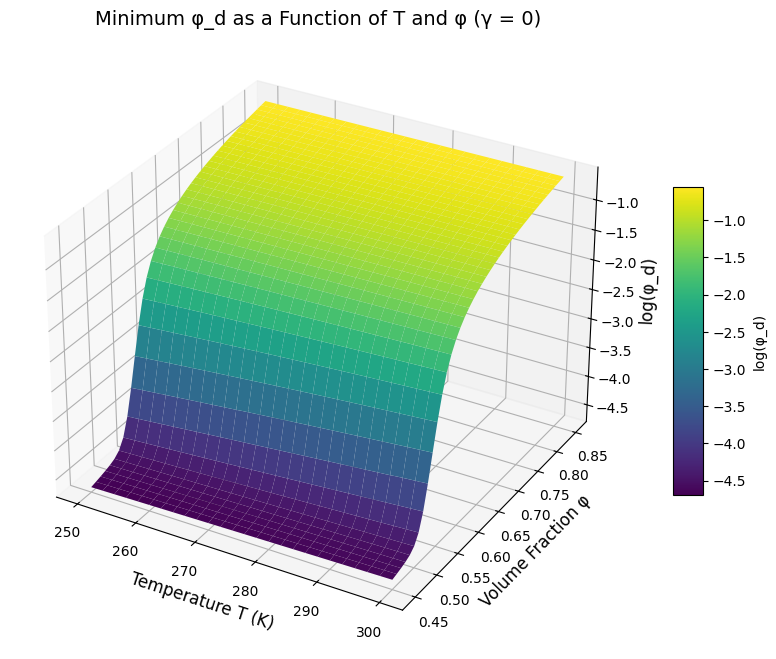

In [12]:
# Prepare ranges for T and phi
T_values = np.linspace(250, 300, 51)  # 51 points from 250 K to 300 K
phi_values = np.linspace(0.45, 0.85, 41)  # 41 points from 0.45 to 0.85

# Meshgrid for T and phi
T_mesh, phi_mesh = np.meshgrid(T_values, phi_values)

# Initialize phi_d_min array
phi_d_min_mesh = np.zeros_like(T_mesh)

# Set gamma = 0
gamma = 0.0

# Compute phi_d_min for each combination of T and phi
for i in range(phi_mesh.shape[0]):
    for j in range(T_mesh.shape[1]):
        phi = phi_mesh[i, j]
        T = T_mesh[i, j]
        phi_d_min, F_min = find_min_phi_d(phi, gamma, T)
        # Handle cases where phi_d_min is negative or NaN
        if np.isnan(phi_d_min) or phi_d_min <= 0:
            phi_d_min_mesh[i, j] = np.nan
        else:
            phi_d_min_mesh[i, j] = phi_d_min

# Plotting the 3D surface with phi_d on a logarithmic scale
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Since phi_d_min may have NaN values, mask them for plotting
phi_d_min_log = np.log10(phi_d_min_mesh)
phi_d_min_log = np.ma.masked_invalid(phi_d_min_log)

# Create the surface plot
surf = ax.plot_surface(T_mesh, phi_mesh, phi_d_min_log, cmap='viridis', edgecolor='none')

# Add labels and title
ax.set_xlabel('Temperature T (K)', fontsize=12)
ax.set_ylabel('Volume Fraction φ', fontsize=12)
ax.set_zlabel('log(φ_d)', fontsize=12)
ax.set_title('Minimum φ_d as a Function of T and φ (γ = 0)', fontsize=14)

# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=10, label='log(φ_d)')

plt.show()

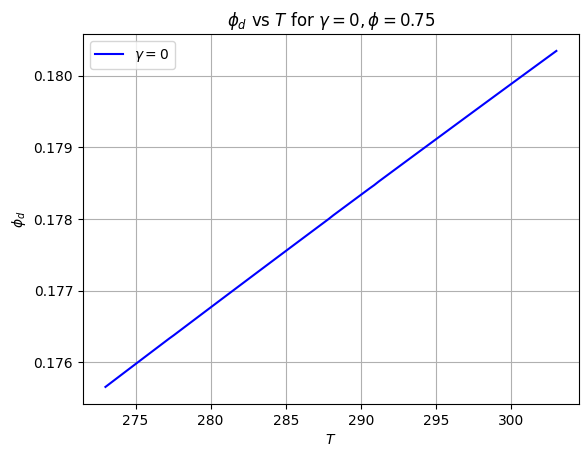

In [13]:
T_values = np.linspace(273, 303, 100)
phi_d_values = [find_min_phi_d(0.75, 0,T)[0] for T in T_values]

# Plotting
plt.plot(T_values, phi_d_values, label=r'$\gamma=0$', color='blue')
plt.xlabel(r'$T$')
plt.ylabel(r'$ \phi_d$')
plt.title(r'$\phi_d$ vs $T$ for $\gamma=0, \phi=0.75$')
plt.legend()
plt.grid(True)
# plt.yscale('log')
plt.show()

# Free energy

In [14]:
T_vals = np.linspace(273, 303, 50)   # 50 points from 273 K to 303 K
phi_vals = np.linspace(0.45, 0.85, 50)  # 50 points from 0.45 to 0.85

# Create meshgrid for T and phi
T_mesh, phi_mesh = np.meshgrid(T_vals, phi_vals)

# Initialize arrays to store results
F_tot_mesh = np.zeros_like(T_mesh)
F_int_mesh = np.zeros_like(T_mesh)
F_ent_mesh = np.zeros_like(T_mesh)
F_elec_mesh = np.zeros_like(T_mesh)
phi_d_star_mesh = np.zeros_like(T_mesh)

gamma = 0  # Given gamma = 0

# Compute values for each combination of T and phi
for i in range(T_mesh.shape[0]):
    for j in range(T_mesh.shape[1]):
        T = T_mesh[i, j]
        phi = phi_mesh[i, j]
        phi_d_star, _ = find_min_phi_d(phi, gamma, T)
        # Handle cases where phi_d_star is NaN or infinite
        if np.isnan(phi_d_star) or np.isinf(phi_d_star):
            F_tot_mesh[i, j] = np.nan
            F_int_mesh[i, j] = np.nan
            F_ent_mesh[i, j] = np.nan
            F_elec_mesh[i, j] = np.nan
            phi_d_star_mesh[i, j] = np.nan
        else:
            F_tot_value = F_tot(phi_d_star, phi, gamma, T)
            # Check for infinite or NaN F_tot_value
            if np.isnan(F_tot_value) or np.isinf(F_tot_value):
                F_tot_mesh[i, j] = np.nan
                F_int_mesh[i, j] = np.nan
                F_ent_mesh[i, j] = np.nan
                F_elec_mesh[i, j] = np.nan
                phi_d_star_mesh[i, j] = np.nan
            else:
                F_tot_mesh[i, j] = F_tot_value
                F_int_mesh[i, j] = F_int(phi_d_star)
                F_ent_mesh[i, j] = F_ent(phi, phi_d_star, gamma, T)
                F_elec_mesh[i, j] = F_elec(phi_d_star, phi, gamma, T)
                phi_d_star_mesh[i, j] = phi_d_star



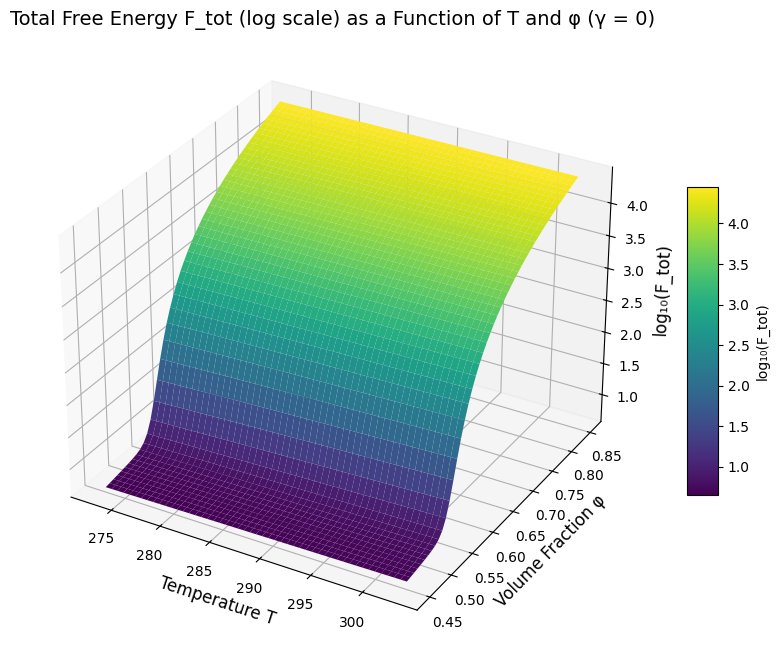

In [15]:
valid_mask = F_tot_mesh > 0
# Initialize an array for log10(F_tot)
log_F_tot_mesh = np.full_like(F_tot_mesh, np.nan)

# Compute log10(F_tot) where F_tot > 0
log_F_tot_mesh[valid_mask] = np.log10(F_tot_mesh[valid_mask]/ (k_B * T))

# Plotting the 3D surface of log10(F_tot) vs T and phi
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Mask NaN values for plotting
log_F_tot_masked = np.ma.masked_invalid(log_F_tot_mesh)

# Create the surface plot
surf = ax.plot_surface(T_mesh, phi_mesh, log_F_tot_masked, cmap='viridis', edgecolor='none')

# Add labels and title
ax.set_xlabel('Temperature T', fontsize=12)
ax.set_ylabel('Volume Fraction φ', fontsize=12)
ax.set_zlabel('log₁₀(F_tot)', fontsize=12)
ax.set_title('Total Free Energy F_tot (log scale) as a Function of T and φ (γ = 0)', fontsize=14)

# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=10, label='log₁₀(F_tot)')

plt.show()

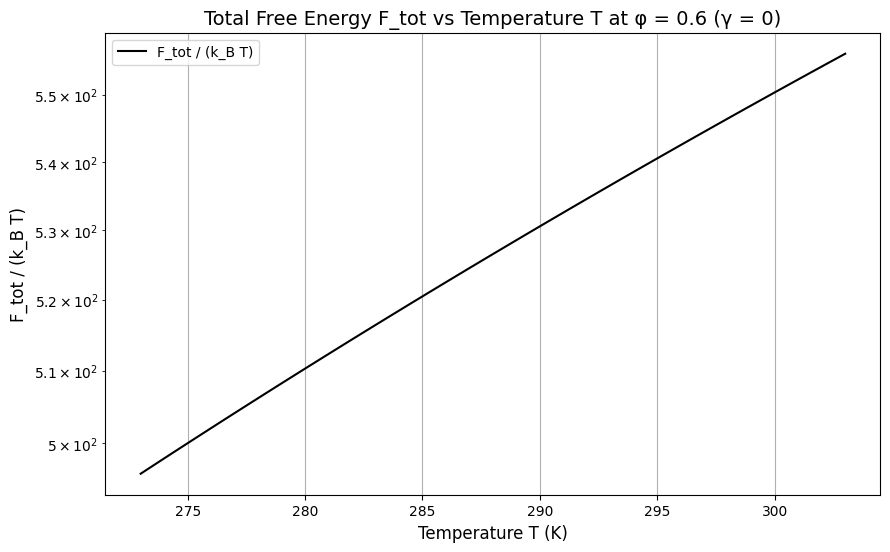

In [16]:
phi_fixed = 0.6  # You can change this value as desired

# Prepare the temperature range
T_vals = np.linspace(273, 303, 100)  # 100 points from 273 K to 303 K

# Initialize arrays to store results
F_tot_vals = []
phi_d_star_vals = []

gamma = 0  # Given gamma = 0

# Compute F_tot for each temperature
for T in T_vals:
    phi_d_star, _ = find_min_phi_d(phi_fixed, gamma, T)
    # Handle cases where phi_d_star is NaN or infinite
    if np.isnan(phi_d_star) or np.isinf(phi_d_star):
        F_tot_vals.append(np.nan)
        phi_d_star_vals.append(np.nan)
    else:
        F_tot_value = F_tot(phi_d_star, phi_fixed, gamma, T)
        # Check for infinite or NaN F_tot_value
        if np.isnan(F_tot_value) or np.isinf(F_tot_value):
            F_tot_vals.append(np.nan)
            phi_d_star_vals.append(phi_d_star)
        else:
            F_tot_vals.append(F_tot_value)
            phi_d_star_vals.append(phi_d_star)

F_tot_vals = np.array(F_tot_vals)
phi_d_star_vals = np.array(phi_d_star_vals)

# Remove NaN values for plotting
valid_indices = ~np.isnan(F_tot_vals)

T_vals_valid = T_vals[valid_indices]
F_tot_vals_valid = F_tot_vals[valid_indices]

# Compute F_tot divided by k_B T
F_tot_scaled = F_tot_vals_valid / (k_B * T_vals_valid)

# Plotting the result
plt.figure(figsize=(10, 6))
plt.plot(T_vals_valid, F_tot_scaled, 'k-', label="F_tot / (k_B T)")
plt.xlabel('Temperature T (K)', fontsize=12)
plt.ylabel('F_tot / (k_B T)', fontsize=12)
plt.title(f'Total Free Energy F_tot vs Temperature T at φ = {phi_fixed} (γ = 0)', fontsize=14)
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

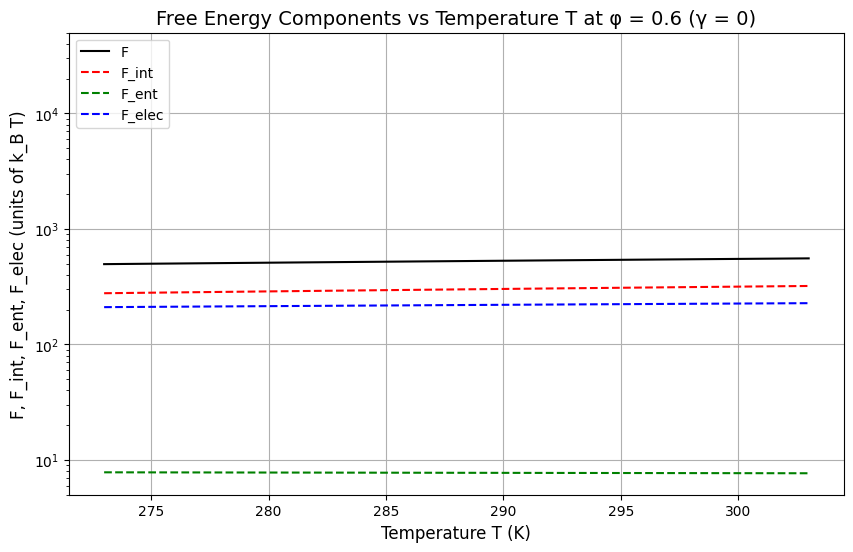

In [17]:
phi_fixed = 0.6  # You can change this value as desired

# Prepare the temperature range
T_vals = np.linspace(273, 303, 100)  # 100 points from 273 K to 303 K

# Initialize arrays to store results
F_tot_vals = []
F_int_vals = []
F_ent_vals = []
F_elec_vals = []
phi_d_star_vals = []

gamma = 0  # Given gamma = 0

# Compute F_tot and its components for each temperature
for T in T_vals:
    phi_d_star, _ = find_min_phi_d(phi_fixed, gamma, T)
    # Handle cases where phi_d_star is NaN or infinite
    if np.isnan(phi_d_star) or np.isinf(phi_d_star):
        F_tot_vals.append(np.nan)
        F_int_vals.append(np.nan)
        F_ent_vals.append(np.nan)
        F_elec_vals.append(np.nan)
        phi_d_star_vals.append(np.nan)
    else:
        F_tot_value = F_tot(phi_d_star, phi_fixed, gamma, T)
        F_int_value = F_int(phi_d_star)
        F_ent_value = F_ent(phi_fixed, phi_d_star, gamma, T)
        F_elec_value = F_elec(phi_d_star, phi_fixed, gamma, T)
        # Check for infinite or NaN F values
        if any(np.isnan([F_tot_value, F_int_value, F_ent_value, F_elec_value])) or any(np.isinf([F_tot_value, F_int_value, F_ent_value, F_elec_value])):
            F_tot_vals.append(np.nan)
            F_int_vals.append(np.nan)
            F_ent_vals.append(np.nan)
            F_elec_vals.append(np.nan)
            phi_d_star_vals.append(phi_d_star)
        else:
            F_tot_vals.append(F_tot_value)
            F_int_vals.append(F_int_value)
            F_ent_vals.append(F_ent_value)
            F_elec_vals.append(F_elec_value)
            phi_d_star_vals.append(phi_d_star)

F_tot_vals = np.array(F_tot_vals)
F_int_vals = np.array(F_int_vals)
F_ent_vals = np.array(F_ent_vals)
F_elec_vals = np.array(F_elec_vals)
phi_d_star_vals = np.array(phi_d_star_vals)

# Remove NaN values for plotting
valid_indices = ~np.isnan(F_tot_vals)

T_vals_valid = T_vals[valid_indices]
F_tot_vals_valid = F_tot_vals[valid_indices]
F_int_vals_valid = F_int_vals[valid_indices]
F_ent_vals_valid = F_ent_vals[valid_indices]
F_elec_vals_valid = F_elec_vals[valid_indices]

# Compute F components divided by k_B T
F_tot_scaled = F_tot_vals_valid / (k_B * T_vals_valid)
F_int_scaled = F_int_vals_valid / (k_B * T_vals_valid)
F_ent_scaled = F_ent_vals_valid / (k_B * T_vals_valid)
F_elec_scaled = F_elec_vals_valid / (k_B * T_vals_valid)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(T_vals_valid, F_tot_scaled, 'k-', label="F")
plt.plot(T_vals_valid, F_int_scaled, 'r--', label="F_int")
plt.plot(T_vals_valid, F_ent_scaled, 'g--', label="F_ent")
plt.plot(T_vals_valid, F_elec_scaled, 'b--', label="F_elec")
plt.yscale('log')
plt.ylim(5, 5e4)
plt.xlabel('Temperature T (K)', fontsize=12)
plt.ylabel('F, F_int, F_ent, F_elec (units of k_B T)', fontsize=12)
plt.title(f'Free Energy Components vs Temperature T at φ = {phi_fixed} (γ = 0)', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# The plateau elastic shear modulus

## use CubicSpline

In [18]:
T = 298

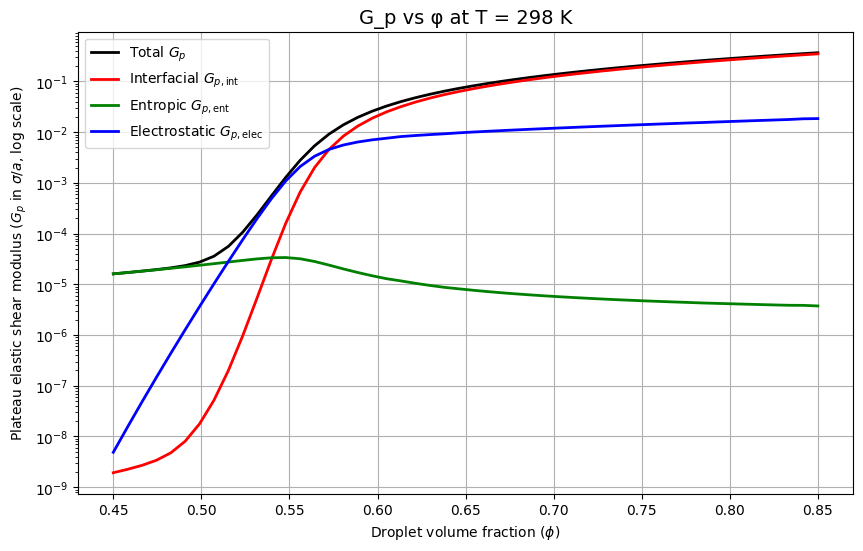

In [20]:
phi_vals = np.linspace(0.45, 0.85, num=50)
gamma_vals = np.linspace(0, 0.01, num=50)

G_p_values = []
G_p_int_values = []
G_p_ent_values = []
G_p_elec_values = []

for phi in phi_vals:
    gamma_list = []
    F_tot_star_list = []
    F_int_star_list = []
    F_ent_star_list = []
    F_elec_star_list = []
    for gamma in gamma_vals:
        phi_d_star, _ = find_min_phi_d(phi, gamma, T)  # Include T here
        if np.isnan(phi_d_star) or np.isinf(phi_d_star):
            F_tot_star = np.nan
            F_int_star = np.nan
            F_ent_star = np.nan
            F_elec_star = np.nan
        else:
            F_tot_star = F_tot(phi_d_star, phi, gamma, T)  # Include T here
            F_int_star = F_int(phi_d_star)
            F_ent_star = F_ent(phi, phi_d_star, gamma, T)  # Include T here
            F_elec_star = F_elec(phi_d_star, phi, gamma, T)  # Include T here
        gamma_list.append(gamma)
        F_tot_star_list.append(F_tot_star)
        F_int_star_list.append(F_int_star)
        F_ent_star_list.append(F_ent_star)
        F_elec_star_list.append(F_elec_star)
    
    gamma_array = np.array(gamma_list)
    F_tot_star_array = np.array(F_tot_star_list)
    F_int_star_array = np.array(F_int_star_list)
    F_ent_star_array = np.array(F_ent_star_list)
    F_elec_star_array = np.array(F_elec_star_list)
    
    # Handle NaN values before interpolation
    valid_indices = ~np.isnan(F_tot_star_array)
    if np.sum(valid_indices) < 4:  # CubicSpline requires at least 4 points
        G_p_values.append(np.nan)
        G_p_int_values.append(np.nan)
        G_p_ent_values.append(np.nan)
        G_p_elec_values.append(np.nan)
        continue
    
    gamma_array_valid = gamma_array[valid_indices]
    F_tot_star_array_valid = F_tot_star_array[valid_indices]
    F_int_star_array_valid = F_int_star_array[valid_indices]
    F_ent_star_array_valid = F_ent_star_array[valid_indices]
    F_elec_star_array_valid = F_elec_star_array[valid_indices]
    
    spline_tot = CubicSpline(gamma_array_valid, F_tot_star_array_valid)
    spline_int = CubicSpline(gamma_array_valid, F_int_star_array_valid)
    spline_ent = CubicSpline(gamma_array_valid, F_ent_star_array_valid)
    spline_elec = CubicSpline(gamma_array_valid, F_elec_star_array_valid)
    
    # Choose a specific gamma value to evaluate the second derivative
    # For example, we can choose gamma = gamma_vals[10]
    gamma_eval = gamma_vals[10]
    
    # Ensure gamma_eval is within the range of gamma_array_valid
    if gamma_eval < gamma_array_valid[0] or gamma_eval > gamma_array_valid[-1]:
        G_p_values.append(np.nan)
        G_p_int_values.append(np.nan)
        G_p_ent_values.append(np.nan)
        G_p_elec_values.append(np.nan)
        continue
    
    second_derivative_tot = spline_tot.derivative(2)(gamma_eval)
    second_derivative_int = spline_int.derivative(2)(gamma_eval)
    second_derivative_ent = spline_ent.derivative(2)(gamma_eval)
    second_derivative_elec = spline_elec.derivative(2)(gamma_eval)
    
    G_p_prime = (phi / V_drop) * second_derivative_tot
    G_p_prime_int = (phi / V_drop) * second_derivative_int
    G_p_prime_ent = (phi / V_drop) * second_derivative_ent
    G_p_prime_elec = (phi / V_drop) * second_derivative_elec
    
    G_p_values.append(G_p_prime)
    G_p_int_values.append(G_p_prime_int)
    G_p_ent_values.append(G_p_prime_ent)
    G_p_elec_values.append(G_p_prime_elec)

G_p_values = np.array(G_p_values)
G_p_int_values = np.array(G_p_int_values)
G_p_ent_values = np.array(G_p_ent_values)
G_p_elec_values = np.array(G_p_elec_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(phi_vals, (G_p_values * a / sigma), label=r'Total $G_p$', lw=2, color='black')
plt.plot(phi_vals, (G_p_int_values * a / sigma), label=r'Interfacial $G_{p,\text{int}}$', lw=2, color='red')
plt.plot(phi_vals, (G_p_ent_values * a / sigma), label=r'Entropic $G_{p,\text{ent}}$', lw=2,  color='green')
plt.plot(phi_vals, (G_p_elec_values * a / sigma), label=r'Electrostatic $G_{p,\text{elec}}$', lw=2,  color='blue')
plt.xlabel(r'Droplet volume fraction ($\phi$)')
plt.ylabel(r'Plateau elastic shear modulus ($G_p$ in $\sigma/a$, log scale)')
plt.title("G_p vs φ at T = 298 K", fontsize=14)
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

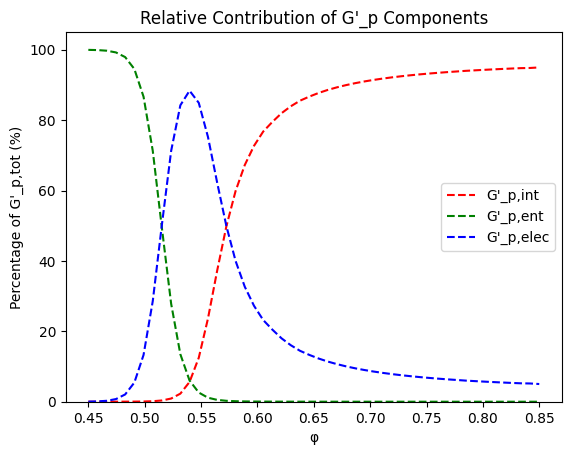

In [21]:
G_p_tot = G_p_int_values + G_p_ent_values + G_p_elec_values

G_p_int_percentage = (G_p_int_values / G_p_tot) * 100
G_p_ent_percentage = (G_p_ent_values / G_p_tot) * 100
G_p_elec_percentage = (G_p_elec_values / G_p_tot) * 100

plt.figure()
plt.plot(phi_vals, G_p_int_percentage, 'r--', label="G'_p,int")   
plt.plot(phi_vals, G_p_ent_percentage, 'g--', label="G'_p,ent")  
plt.plot(phi_vals, G_p_elec_percentage, 'b--', label="G'_p,elec") 
plt.xlabel('φ')
plt.ylabel("Percentage of G'_p,tot (%)")
plt.ylim(0, 105)  
plt.legend()
plt.title("Relative Contribution of G'_p Components")
plt.show()

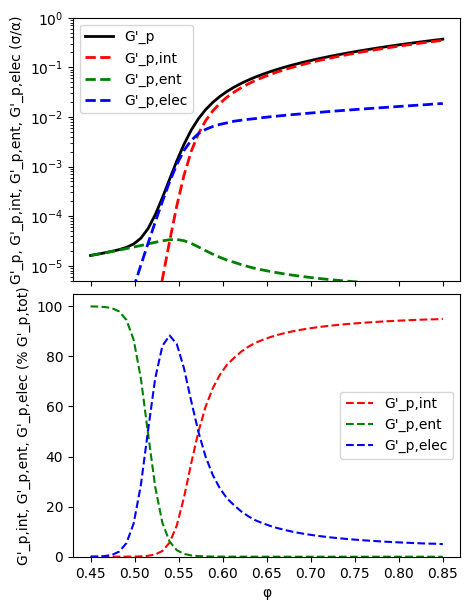

In [23]:
fig = plt.figure(figsize=(5, 7))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)


ax1 = fig.add_subplot(gs[0])
ax1.plot(phi_vals, (G_p_values * a / sigma), 'k-', label="G'_p", lw=2)
ax1.plot(phi_vals, (G_p_int_values * a / sigma), 'r--', label="G'_p,int", lw=2)
ax1.plot(phi_vals, (G_p_ent_values * a / sigma), 'g--', label="G'_p,ent", lw=2)
ax1.plot(phi_vals, (G_p_elec_values * a / sigma), 'b--', label="G'_p,elec", lw=2)
ax1.set_yscale('log')
ax1.set_ylim(5*10e-7, 1)
ax1.set_ylabel("G'_p, G'_p,int, G'_p,ent, G'_p,elec (σ/α)")
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(phi_vals, G_p_int_percentage, 'r--', label="G'_p,int")
ax2.plot(phi_vals, G_p_ent_percentage, 'g--', label="G'_p,ent")
ax2.plot(phi_vals, G_p_elec_percentage, 'b--', label="G'_p,elec")
ax2.set_xlabel('φ')
ax2.set_ylabel("G'_p,int, G'_p,ent, G'_p,elec (% G'_p,tot)")
ax2.set_ylim(0, 105)
ax2.legend(loc='center right')

plt.setp(ax1.get_xticklabels(), visible=False)

plt.show()

# End
